In [20]:
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse

from ppx import PrideProject
from Bio.SeqUtils.ProtParam import ProteinAnalysis

sys.path.append("..")
import src

primary, accent = src.theme.set()
pal = sns.color_palette("wfondrie")

def save(fname):
    """Save the figures"""
    figures = Path("figures")
    figures.mkdir(exist_ok=True)
    if not fname.startswith("01_"):
        fname = "01_" + fname
        
    if not fname.endswith(".png"):
        fname += ".png"
    
    plt.tight_layout(pad=0.2)
    plt.savefig(figures / fname, dpi=300)

    
def label(ax=None):
    """Add labels to the plot"""
    if ax is None:
        ax = plt.gca()
        
    ax.set_xlabel("GRAVY Score")
    ax.set_ylabel("Retention Time (min)")


def load_data(n_test=15):
    """Load the PROCAL data"""
    fname = "Skyline_output_all_runs.csv"
    proj = PrideProject("PXD006832")
    rt_csv = proj.local_files(fname)
    if not rt_csv:
        rt_csv = proj.download(fname)
        
    df = pd.read_csv(rt_csv[0])
    
    stem = "161207_ProPep_50fmol_4to42_R1"
    has_stem = df["Replicate Name"].str.contains(stem)
    df = df.loc[has_stem, :]
    df["Peptide GRAVY Score"] = (
        df["Peptide Sequence"]
        .apply(lambda x: ProteinAnalysis(x).gravy())
    )
    
    df = df.sample(frac=1, random_state=42)
    n_train = len(df) - n_test
    
    train_df = df.iloc[:n_train, :]
    train = (
        train_df["Peptide GRAVY Score"].to_numpy()[:, None],
        train_df["Peptide Retention Time"].to_numpy(),
    )
    
    test_df = df.iloc[n_train:, :]
    test = (
        test_df["Peptide GRAVY Score"].to_numpy()[:, None],
        test_df["Peptide Retention Time"].to_numpy(),
    )
    space = np.linspace(
        df["Peptide GRAVY Score"].min(),
        df["Peptide GRAVY Score"].max(),
        1000,
    )
    return train, test, space
    
    
train, test, space = load_data()
lm = LinearRegression().fit(*train)
nn = MLPRegressor((128, 128), max_iter=10000, solver="lbfgs", random_state=1).fit(*train)

lm_train = lm.predict(train[0])
nn_train = nn.predict(train[0])
lm_test = lm.predict(test[0])
nn_test = nn.predict(test[0])

print("lm:", mse(lm_train, train[1]),  mse(lm_test, test[1]))
print("nn:", mse(nn_train, train[1]),  mse(nn_test, test[1]))

lm: 49.00412572148807 28.279195657445783
nn: 5.624395830334286 88.87151435102584


# Example

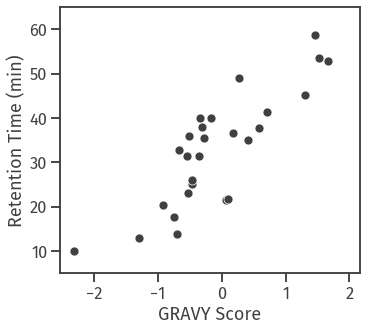

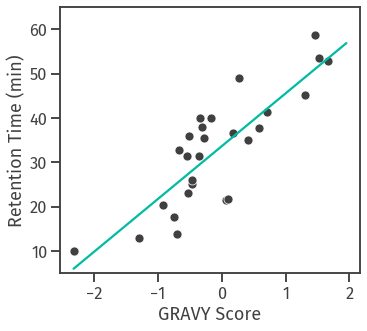

In [2]:
ylim = (5, 65)

plt.figure(figsize=(5, 4.5))
sns.scatterplot(x=train[0][:, 0], y=train[1], color=primary)
sns.scatterplot(x=test[0][:, 0], y=test[1], color="white", zorder=0)
plt.ylim(*ylim)
label()
save("rt_train")

plt.figure(figsize=(5, 4.5))
sns.scatterplot(x=train[0][:, 0], y=train[1], color=primary)
sns.scatterplot(x=test[0][:, 0], y=test[1], color="white", zorder=0)
sns.lineplot(x=space, y=lm.predict(space[:, None]))
plt.ylim(*ylim)

label()
save("rt_train_lm")

# Mean squared error

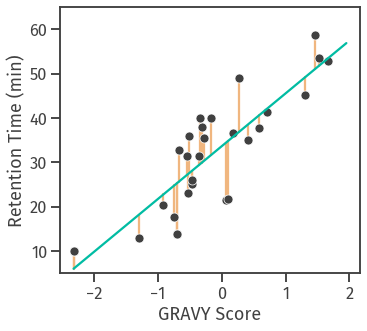

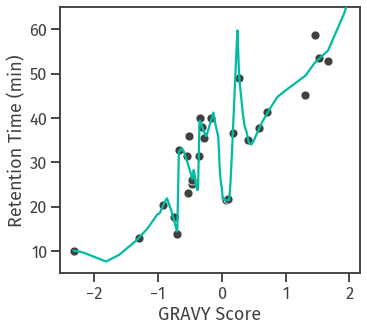

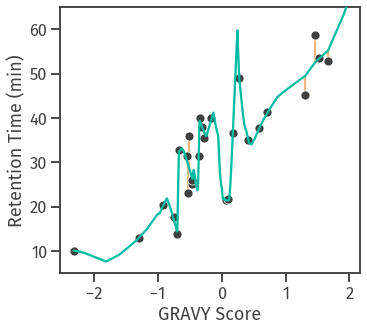

In [3]:
plt.figure(figsize=(5, 4.5))
sns.scatterplot(x=train[0][:, 0], y=train[1], color=primary, zorder=2)
sns.scatterplot(x=test[0][:, 0], y=test[1], color="white", zorder=0)
sns.lineplot(x=space, y=lm.predict(space[:, None]), zorder=3)
plt.ylim(*ylim)

err = np.vstack([train[1], lm_train])
xloc = np.hstack([train[0], train[0]]).T
plt.plot(xloc, err, color=pal[1], zorder=1)
label()
save("rt_train_lm_err")

# Neural network:
plt.figure(figsize=(5, 4.5))
sns.scatterplot(x=train[0][:, 0], y=train[1], color=primary, zorder=2)
sns.scatterplot(x=test[0][:, 0], y=test[1], color="white", zorder=0)
sns.lineplot(x=space, y=nn.predict(space[:, None]), zorder=3)
plt.ylim(*ylim)
label()
save("rt_train_nn")

plt.figure(figsize=(5, 4.5))
sns.scatterplot(x=train[0][:, 0], y=train[1], color=primary, zorder=2)
sns.scatterplot(x=test[0][:, 0], y=test[1], color="white", zorder=0)
sns.lineplot(x=space, y=nn.predict(space[:, None]), zorder=3)
plt.ylim(*ylim)

err = np.vstack([train[1], nn_train])
xloc = np.hstack([train[0], train[0]]).T
plt.plot(xloc, err, color=pal[1], zorder=1)
label()
save("rt_train_nn_err")

# Split yo data

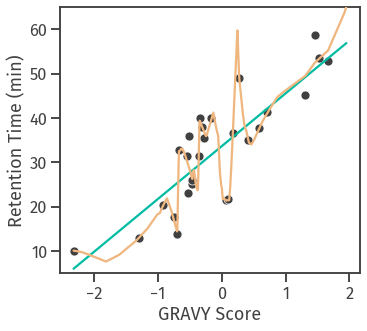

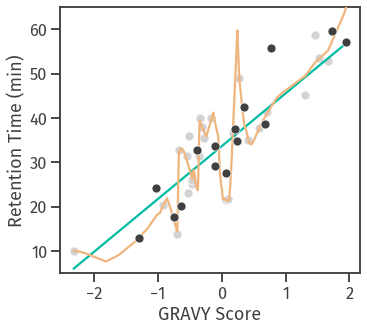

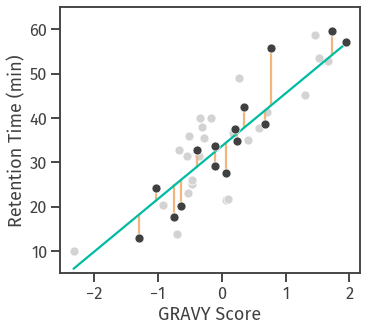

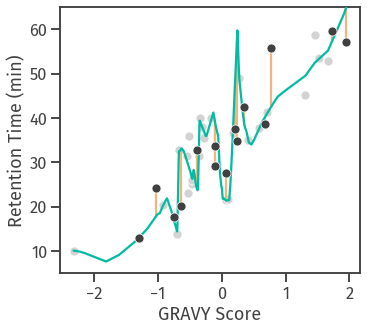

In [4]:
plt.figure(figsize=(5, 4.5))
sns.scatterplot(x=train[0][:, 0], y=train[1], color=primary, zorder=2)
sns.scatterplot(x=test[0][:, 0], y=test[1], color="white", zorder=0)
sns.lineplot(x=space, y=lm.predict(space[:, None]))
sns.lineplot(x=space, y=nn.predict(space[:, None]), zorder=3)
plt.ylim(*ylim)
label()
save("rt_train_lm-nn")

plt.figure(figsize=(5, 4.5))
sns.scatterplot(x=train[0][:, 0], y=train[1], color="lightgrey", zorder=2)
sns.scatterplot(x=test[0][:, 0], y=test[1], color=primary, zorder=4)
sns.lineplot(x=space, y=lm.predict(space[:, None]))
sns.lineplot(x=space, y=nn.predict(space[:, None]), zorder=3)
plt.ylim(*ylim)
label()
save("rt_test_lm-nn")

# With errors:
plt.figure(figsize=(5, 4.5))
sns.scatterplot(x=train[0][:, 0], y=train[1], color="lightgrey", zorder=1)
sns.scatterplot(x=test[0][:, 0], y=test[1], color=primary, zorder=4)
sns.lineplot(x=space, y=lm.predict(space[:, None]), zorder=3)
plt.ylim(*ylim)

err = np.vstack([test[1], lm_test])
xloc = np.hstack([test[0], test[0]]).T
plt.plot(xloc, err, color=pal[1], zorder=2)
label()
save("rt_test_lm_err")

# With errors:
plt.figure(figsize=(5, 4.5))
sns.scatterplot(x=train[0][:, 0], y=train[1], color="lightgrey", zorder=1)
sns.scatterplot(x=test[0][:, 0], y=test[1], color=primary, zorder=4)
sns.lineplot(x=space, y=nn.predict(space[:, None]), zorder=3)
plt.ylim(*ylim)

err = np.vstack([test[1], nn_test])
xloc = np.hstack([test[0], test[0]]).T
plt.plot(xloc, err, color=pal[1], zorder=2)
label()
save("rt_test_nn_err")



lm: 49.00412572148807 28.279195657445783
nn: 5.624395830334286 88.87151435102584


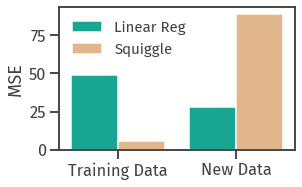

In [5]:

print("lm:", mse(lm_train, train[1]),  mse(lm_test, test[1]))
print("nn:", mse(nn_train, train[1]),  mse(nn_test, test[1]))

mse_data = (
    ("Linear Reg", "Training Data", mse(lm_train, train[1])),
    ("Linear Reg", "New Data", mse(lm_test, test[1])),
    ("Squiggle", "Training Data", mse(nn_train, train[1])),
    ("Squiggle", "New Data", mse(nn_test, test[1])),
)

mse_df = pd.DataFrame(mse_data, columns=["Model", "Data", "MSE"])

mse_df

plt.figure(figsize=(4.1, 2.5))
sns.barplot(data=mse_df, x="Data", y="MSE", hue="Model")
plt.xlabel("")
plt.legend(title="", loc="upper left", fontsize="small")
save("mse")


# Bias-Variance Tradeoff

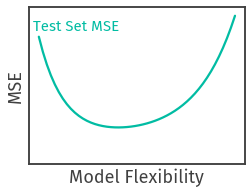

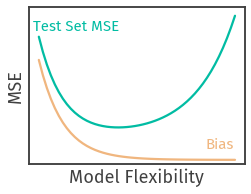

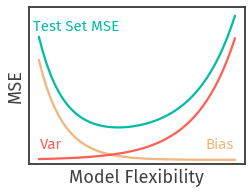

In [82]:
X = np.linspace(0.001, 5)
bias = 1/5**(X-0.5)
var = 1/np.exp(4-X)
loss = bias + var + 0.5

plt.figure(figsize=(3.4, 2.6))
plt.plot(X, loss)
plt.annotate(
    "Test Set MSE", 
    (0.02, 0.85), 
    xycoords="axes fraction", 
    fontsize="small",
    color=pal[0],
)
plt.xlabel("Model Flexibility")
plt.ylabel("MSE")
plt.xticks([])
plt.yticks([])
plt.ylim(-0.1, loss.max()+0.2)
save("bias-var0")

plt.figure(figsize=(3.4, 2.6))
plt.plot(X, loss)
plt.plot(X, bias)
plt.annotate(
    "Test Set MSE", 
    (0.02, 0.85), 
    xycoords="axes fraction", 
    fontsize="small",
    color=pal[0],
)
plt.annotate(
    "Bias", 
    (0.95, 0.1), 
    xycoords="axes fraction", 
    fontsize="small",
    color=pal[1],
    ha="right",
)

plt.xlabel("Model Flexibility")
plt.ylabel("MSE")
plt.xticks([])
plt.yticks([])
plt.ylim(-0.1, loss.max()+0.2)
save("bias-var1")

plt.figure(figsize=(3.4, 2.6))
plt.plot(X, loss)
plt.plot(X, bias)
plt.plot(X, var)
plt.annotate(
    "Test Set MSE", 
    (0.02, 0.85), 
    xycoords="axes fraction", 
    fontsize="small",
    color=pal[0],
)
plt.annotate(
    "Bias", 
    (0.95, 0.1), 
    xycoords="axes fraction", 
    fontsize="small",
    color=pal[1],
    ha="right",
)
plt.annotate(
    "Var", 
    (0.05, 0.1), 
    xycoords="axes fraction", 
    fontsize="small",
    color=pal[2],
    ha="left",
)
plt.xlabel("Model Flexibility")
plt.ylabel("MSE")
plt.xticks([])
plt.yticks([])
plt.ylim(-0.1, loss.max()+0.2)
save("bias-var2")